# 1,インストール・インポート

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
#ここで必要なもの全てインストール
!pip install japanize-matplotlib  
!pip install ydata-profiling 
!pip install sweetviz
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=1d279f4c0947c64a43f1be233af12ba78455a8956f6645462ec8155f2715e2ac
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 85.8 MB/s eta 0:00:00:00:010:01


In [3]:
# #標準装備のnumpy2.0ではsweetvizが動かないためバージョンをさげる
# !pip install --force-reinstall numpy==1.26.4 #保存時のみrun allができなくくてエラーが出るのでコメントアウトする


In [4]:
# モジュールのインポート
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import japanize_matplotlib
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import sweetviz as sv #sweetvizを用いるため
import lightgbm as lgb
import xgboost as xgb
from scipy import stats#サイパイでウィルコクソンの順位和検定を行うため
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from ydata_profiling import ProfileReport#YData-ProfilingというEDAツールを使うため
from catboost import CatBoostClassifier#catboostを使うため
from sklearn.model_selection import train_test_split#データを学習用と検証用にわける
from sklearn.linear_model import LogisticRegression#ロジスティック回帰モデルをベースラインモデルとして作るため
from sklearn.preprocessing import StandardScaler#標準化するため
from sklearn.pipeline import Pipeline#前処理とモデルをまとめて順番通りに自動でやってくれる箱
from sklearn.model_selection import cross_val_score#ロジスティック回帰モデル用のデータを分けるため
from matplotlib.ticker import MultipleLocator#一定間隔でメモリをおく
from scipy.stats import mannwhitneyu#ウィルコクソンの順位和検定のため
from sklearn.cluster import KMeans#k-means法を用いるため　これでクラスタリングを行う


In [5]:
#できてるかの確認
print(np.__version__)

2.0.2


# 2,データの概要

In [6]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## カラム名の和訳(英語では概要をつかみにくいので)

番号,カラム名,日本語訳・意味<br>
0,Id,物件ID<br>
1,MSSubClass,建物の等級（1階建て、2階建て、新築など）<br>
2,MSZoning,用途地域区分（商業、住宅など）<br>
3,LotFrontage,道路に接している長さ（フィート）<br>
4,LotArea,敷地面積（平方フィート）<br>
5,Street,道路の舗装状態（砂利、舗装）<br>
6,Alley,路地へのアクセスの種類<br>
7,LotShape,敷地の形状（規則的、不規則）<br>
8,LandContour,土地の平坦さ<br>
9,Utilities,利用可能な公共サービス（水道、電気など）<br>
10,LotConfig,敷地の区画構成（角地など）<br>
11,LandSlope,土地の傾斜<br>
12,Neighborhood,エイムス市内の地区名（立地）<br>
13,Condition1,幹線道路や鉄道への近接性<br>
14,Condition2,幹線道路や鉄道への近接性（複数ある場合）<br>
15,BldgType,建物の種類（戸建て、タウンハウスなど）<br>
16,HouseStyle,住宅のスタイル（平屋、2階建てなど）<br>
17,OverallQual,全体の素材と仕上げの品質（1-10評価）<br>
18,OverallCond,全体的な状態の評価（1-10評価）<br>
19,YearBuilt,建設年<br>
20,YearRemodAdd,改築・リフォーム年<br>
21,RoofStyle,屋根の形状<br>
22,RoofMatl,屋根の素材<br>
23,Exterior1st,外壁材1<br>
24,Exterior2nd,外壁材2<br>
25,MasVnrType,外装用石積みの種類<br>
26,MasVnrArea,外装用石積みの面積<br>
27,ExterQual,外装材の品質評価<br>
28,ExterCond,外装材の状態評価<br>
29,Foundation,基礎の種類（コンクリートなど）<br>
30,BsmtQual,地下室の高さ（品質評価）<br>
31,BsmtCond,地下室の全体的な状態<br>
32,BsmtExposure,地下室の露出具合（外光、換気）<br>
33,BsmtFinType1,地下室の仕上げ評価1<br>
34,BsmtFinSF1,地下室の仕上げ面積1<br>
35,BsmtFinType2,地下室の仕上げ評価2<br>
36,BsmtFinSF2,地下室の仕上げ面積2<br>
37,BsmtUnfSF,地下室の未仕上げ面積<br>
38,TotalBsmtSF,地下室の総面積<br>
39,Heating,暖房の種類<br>
40,HeatingQC,暖房の品質と状態<br>
41,CentralAir,セントラルエアコンの有無（Y/N）<br>
42,Electrical,電気システム<br>
43,1stFlrSF,1階の面積<br>
44,2ndFlrSF,2階の面積<br>
45,LowQualFinSF,低品質な仕上げの面積（全フロア）<br>
46,GrLivArea,地上の居住面積合計（平方フィート）<br>
47,BsmtFullBath,地下室のフルバスルーム数<br>
48,BsmtHalfBath,地下室のハーフバスルーム数<br>
49,FullBath,地上のフルバスルーム数<br>
50,HalfBath,地上のハーフバスルーム数<br>
51,BedroomAbvGr,地上のベッドルーム数<br>
52,KitchenAbvGr,地上のキッチン数<br>
53,KitchenQual,キッチンの品質評価<br>
54,TotRmsAbvGrd,地上の総部屋数（バスルーム除く）<br>
55,Functional,住宅の機能性評価<br>
56,Fireplaces,暖炉の数<br>
57,FireplaceQu,暖炉の品質<br>
58,GarageType,ガレージの種類<br>
59,GarageYrBlt,ガレージの建設年<br>
60,GarageFinish,ガレージの内装仕上げ具合<br>
61,GarageCars,ガレージの収容台数<br>
62,GarageArea,ガレージの面積<br>
63,GarageQual,ガレージの品質<br>
64,GarageCond,ガレージの状態<br>
65,PavedDrive,ドライブウェイ（私道）の舗装状態<br>
66,WoodDeckSF,ウッドデッキの面積<br>
67,OpenPorchSF,オープンポーチの面積<br>
68,EnclosedPorch,囲いのあるポーチの面積<br>
69,3SsnPorch,三季用ポーチの面積<br>
70,ScreenPorch,スクリーンポーチ（網戸付き）の面積<br>
71,PoolArea,プールの面積<br>
72,PoolQC,プールの品質<br>
73,Fence,柵の品質<br>
74,MiscFeature,その他（テニスコート、納屋など）<br>
75,MiscVal,その他特徴の価値<br>
76,MoSold,売却月<br>
77,YrSold,売却年<br>
78,SaleType,販売の種類<br>
79,SaleCondition,販売条件<br>
80,SalePrice,販売価格（予測するターゲット）<br>

# 3,EDA

In [17]:
#insull().sum()に追加で.to_stiringメソッドを追加することにより全行表示が可能(今回はしない)
#pandasではデータフレーム[True/Falseのリスト] と書くと、Trueの行だけを抽出するというルールがある
#[]により先に比較演算が行われる
train_null_df=train.isnull()
train_null=train.isnull().sum()
train_null=train_null[train_null>0]
print(train_null)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [11]:
#df名[df名　比較演算子　数]　→これによりdfの中でも条件を満たした行のみが取り出される
test_null=test.isnull().sum()
test_null=test_null[test_null>0]
print(test_null)


MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


In [12]:
#pd.concat([,])で二つのdfの接合が可能  axis=1は横方向に接続という意味
#.columnsメソッドでカラム名を指定
#.filina(0)で欠損値を0にする
#>0で0より大きいならTrue、0より小さにならFalse(bool型にしてる)
#.astype(int)メソッドによりTrueが1、falseが0になる(boola型をint型へ)
df_null=pd.concat([train_null,test_null],axis=1)
df_null.columns=['train_null','test_null']
df_null=(df_null.fillna(0)>-0).astype(int)

print(df_null)

              train_null  test_null
LotFrontage            1          1
Alley                  1          1
MasVnrType             1          1
MasVnrArea             1          1
BsmtQual               1          1
BsmtCond               1          1
BsmtExposure           1          1
BsmtFinType1           1          1
BsmtFinType2           1          1
Electrical             1          0
FireplaceQu            1          1
GarageType             1          1
GarageYrBlt            1          1
GarageFinish           1          1
GarageQual             1          1
GarageCond             1          1
PoolQC                 1          1
Fence                  1          1
MiscFeature            1          1
MSZoning               0          1
Utilities              0          1
Exterior1st            0          1
Exterior2nd            0          1
BsmtFinSF1             0          1
BsmtFinSF2             0          1
BsmtUnfSF              0          1
TotalBsmtSF            0    

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 81/81 [00:01<00:00, 41.94it/s]


KeyboardInterrupt: 

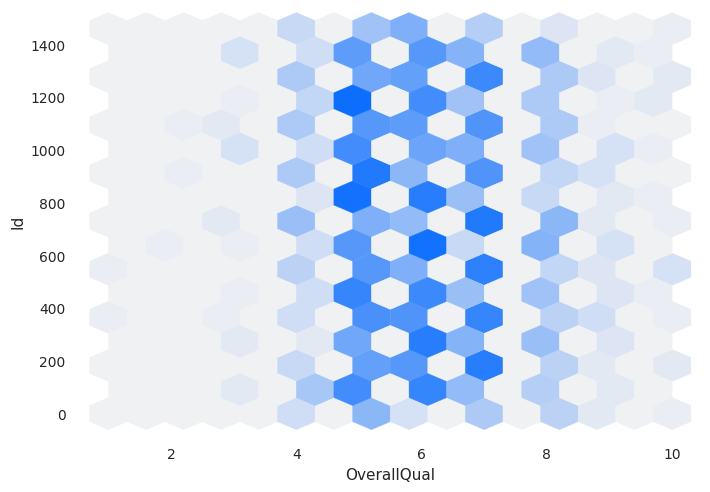

In [13]:
#YData-Profilingの実行
from ydata_profiling import ProfileReport
profile = ProfileReport(train, title="ydata-profilingによるEDA結果", explorative=True)

# 4. レポートをノートブック上に表示
profile.to_notebook_iframe()

# 5. HTMLとして保存
profile.to_file("ydata_analysis.html")

In [ ]:
# #保存時はnumpyのバージョンを下げることが出ずにエラーがでるのでコメントアウト
# sweetviz_report = sv.analyze(train, target_feat='SalePrice')

# #ここでnotebook上の表示
# sweetviz_report.show_notebook()

# # レポートをHTMLで出力して表示
# sweetviz_report.show_html("Sweetviz_Report.html")

# 4,前処理

In [15]:
#.dropメソッドで()にカラム名とaxisで行か列を指定すると消える
train=train.drop('Id',axis=1)
test=test.drop('Id',axis=1)

## (1)trainの欠損値処理

・LotFrontage has 259 (17.7%) missing valuesなのでIterativeImputer<br>
・LotFrontage has 259 (17.7%) missing valuesなのでこれはIterativeImputer<br>
・Alley has 1369 (93.8%) missing valuesなのでこれは明らか欠損多いので手動<br>
・MasVnrType has 872 (59.7%) missing valuesなので少し多いので手動<br>
・BsmtQual has 37 (2.5%) missing valuesなのでIterativeImputer<br>
・BsmtCond has 37 (2.5%) missing valuesなのでIterativeImputer<br>
・BsmtExposure has 38 (2.6%) missing valuesなのでIterativeImputer<br>	
・BsmtFinType1 has 37 (2.5%) missing valuesなのでIterativeImputer<br>
・BsmtFinType2 has 38 (2.6%) missing valuesなのでIterativeImputer<br>
・FireplaceQu has 690 (47.3%) missing valuesなので少し多いので手動<br>
・GarageType has 81 (5.5%) missing valuesなのでIterativeImput<br>
・GarageYrBlt has 81 (5.5%) missing valuesなのでIterativeImput	<br>
・GarageFinish has 81 (5.5%) missing valuesなのでIterativeImput	<br>
・GarageQual has 81 (5.5%) missing valuesなのでIterativeImput	<br>
・GarageCond has 81 (5.5%) missing valuesなのでIterativeImput<br>
・PoolQC has 1453 (99.5%) missing values多いので手動	<br>
・Fence has 1179 (80.8%) missing values	多いので手動<br>
・MiscFeature has 1406 (96.3%) missing 多いので手動<br>

ここから手動で補完するためにどのような種類がそのカラムの中にあるのか調べていく

In [24]:
# 調べたいカラムのリスト
target_cols = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

for col in target_cols:
    print(f"{col} の中身")
    # .value_countsメソッドで種類を数えることが可能  dropna=Falseで欠損値込みで数える
    print(train[col].value_counts(dropna=False))
    print('\n')#\nで改行が可能
    

Alley の中身
Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64


MasVnrType の中身
MasVnrType
NaN        872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64


FireplaceQu の中身
FireplaceQu
NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: count, dtype: int64


PoolQC の中身
PoolQC
NaN    1453
Gd        3
Ex        2
Fa        2
Name: count, dtype: int64


Fence の中身
Fence
NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: count, dtype: int64


MiscFeature の中身
MiscFeature
NaN     1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64




明日はtrainの手動と自動欠陥補完　testの手動自動見極めで欠陥補完も終わらす
またYdataからわかる前処理を終わらす。相関とかは特徴量エンジニアリングの時に使うので今は使わないから早くおわるはず
これが終わったらencoding
あと本の第3章の4まで読み終える。欠損値補完とエンコーディングに役たつ